# Part 2
##  Exercise: Use the concept of modularity to explore how community-like the genres are.
### Explain the concept of modularity in your own words.

Modularity in community detection is a way to evaluate the quality of partitioning/division of a network into different groups/communities. It computes how well the network is divided, where a group/community consists of nodes that are more densely connected to each other than to nodes in other groups.

According to ([chapter 9](https://networksciencebook.com/chapter/9#modularity)) the formula to calculate modularity is:


#### Modularity $M$ for a Single Community:

For a community $C_c$ consisting of $N_c$ nodes and $L_c$ links, the modularity $M_c$ is given by:

$$
M_c = \frac{1}{2L} \sum_{(i,j) \in C_c} \left( A_{ij} - p_{ij} \right)
$$

Where:
- $A_{ij}$: Adjacency matrix.
- $p_{ij} = \frac{k_i k_j}{2L}$: The probability that an edge exists between nodes $i$ and $j$ in a randomized network with the same degree distribution, where $k_i$ and $k_j$ are the degrees of nodes $i$ and $j$, respectively.
- $L$: The total number of links in the entire network.
- The sum $\sum_{(i,j) \in C_c}$ is over all pairs of nodes within the community $C_c$.

This formula measures how much the actual number of links between nodes in the community $C_c$ exceeds (or falls short of) the expected number of links in a randomly wired network.

#### Simplified Modularity for a Single Community:

Using the degree-preserving null model for random networks $p_{ij} = \frac{k_i k_j}{2L}$, the modularity for a single community $C_c$ simplifies to:

$$
M_c = \frac{L_c}{L} - \left( \frac{k_c}{2L} \right)^2
$$

Where:
- $L_c$: The number of links within the community $C_c$.
- $k_c$: The total degree of all nodes in the community $C_c$ (i.e., the sum of the degrees of all nodes in $C_c$).

#### Generalized Modularity for the Whole Network:

To generalize the modularity for the entire network, partitioned into $n_c$ communities, we sum the modularity over all communities:

$$
M = \sum_{c=1}^{n_c} \left( \frac{L_c}{L} - \left( \frac{k_c}{2L} \right)^2 \right)
$$

Where:
- $L$: The total number of links in the entire network.
- $L_c$: The number of links inside community $C_c$.
- $k_c$: The total degree of nodes within community $C_c$.
- $n_c$: The total number of communities.

#### Interpretation of the Modularity Formula:
- $M_c$ measures how much the community $C_c$'s structure deviates from a random network structure.
- If $M_c > 0$, the community $C_c$ has more links than expected, and it may represent a meaningful community.
- If $M_c = 0$, the community is no different from a random configuration.
- If $M_c < 0$, the community has fewer links than expected, suggesting that it may not be a true community.
- The total modularity $M$ gives a measure of how well the network is divided into communities. A high value of $M$ (typically close to 1) indicates a strong community structure.



### Now create your own partition of the network into genres

First lets create the network from the file with infoboxes.


In [98]:
import json
import networkx as nx
import pickle
import random
import matplotlib.pyplot as plt

# Load genre data from infoboxes.txt
file_path_genre = '/Users/aya/Desktop/Skole/social_graps/Aya/shared/infoboxes.txt'
with open(file_path_genre, 'r') as file:
    data = json.load(file)

# Load the graph from performer_network.pkl
file_path_graph = '/Users/aya/Desktop/Skole/social_graps/Aya/shared/performer_network.pkl'
with open(file_path_graph, 'rb') as f:
    G = pickle.load(f)

# Add genre attribute to each artist node in the graph
for artist, genres in data.items():
    if artist in G.nodes:  # Only update nodes that exist in the graph
        G.nodes[artist]['genre'] = genres  # Add the 'genre' attribute

# Check the nodes to confirm 'genre' attribute was added
print("Sample nodes with 'genre' attribute:")
for node, attr in list(G.nodes(data=True))[:5]:  # Display first 5 nodes as a sample
    print(node, attr)


# Display the number of nodes and edges in the graph
num_nodes = G.number_of_nodes()
num_edges = G.number_of_edges()

print(f"Number of nodes: {num_nodes}")
print(f"Number of edges: {num_edges}")


Sample nodes with 'genre' attribute:
Bryan Austin {'word_count': 951, 'genre': ['country']}
Gene Autry {'word_count': 12995, 'genre': ['country', 'western']}
Reba McEntire {'word_count': 21253, 'genre': ['country', 'gospel']}
Lee Brice {'word_count': 3189, 'genre': ['country']}
Leland Martin {'word_count': 449, 'genre': ['country']}
Number of nodes: 1939
Number of edges: 17578


In [99]:
# Partition the graph based on the first genre in the list of genres
genre_communities = {}

# Iterate over the nodes (artists) in the graph
for artist in G.nodes:
    # Ensure the node has a 'genre' attribute
    if 'genre' in G.nodes[artist] and G.nodes[artist]['genre']:
        # Get the first genre from the genre list
        first_genre = G.nodes[artist]['genre'][0]
        
        # Add artist to the corresponding genre community
        if first_genre not in genre_communities:
            genre_communities[first_genre] = []
        genre_communities[first_genre].append(artist)


### Now calculate the modularity of this division of the network into genres.

We will use eq 9.12 from the book:

$$
M = \sum_{c=1}^{n_c} \left( \frac{L_c}{L} - \left( \frac{k_c}{2L} \right)^2 \right)
$$


In [100]:
 # Calculate the total number of links (L_c) in a community.
def calculate_Lc(graph, community_nodes):

    total_degree = 0
 
    for node in community_nodes:
        total_degree += graph.degree(node)
    
    # Each edge is counted twice in the degree, so divide by 2
    L_c = total_degree / 2
    
    return int(L_c)


def calculate_modularity(graph, genre_communities):
    """
    Calculate the modularity M of the graph based on the partition into genres.
    
    Parameters:
    graph: The undirected graph.
    genre_communities (dict): A dictionary where the key is the genre and the value is a list of nodes (artists) in that genre.
    
    Returns:
    M (float): The modularity score.
    """
    # Total number of edges in the graph (L)
    L = graph.number_of_edges()
    
    modularity = 0
    
    # Iterate over each community 
    for genre, community_nodes in genre_communities.items():
        # Calculate L_c 
        L_c = calculate_Lc(graph, community_nodes) 
        
        # Calculate k_c (the sum of the degrees of the nodes in the community)
        k_c = sum([graph.degree(node) for node in community_nodes])
        
        # Calculate the modularity contribution for this community
        modularity += (L_c / L) - ((k_c / (2 * L)) ** 2)
    
    return modularity



modularity = calculate_modularity(G, genre_communities)

print(f"Modularity of the partitioning into genres: {modularity}")


Modularity of the partitioning into genres: 0.547869645320337


!!!!FIX THIS

The modularity score is 0.369 which is moderate - which is a good score, but it doesn't necessarily indicate that the partition into genres is the best community structure. We will try to grab the first genre that's not country as the genre-assignment for all nodes that have more than one genre - as suggested.

In [101]:
# Adjust partition to grab the first genre that isn't 'country'
genre_communities = {}

# Iterate over the nodes (artists) in the graph
for artist in G.nodes:
    # Get the list of genres
    genres = G.nodes[artist].get('genre', [])
    
    # Find the first genre that isn't 'country'
    first_non_country_genre = next((genre for genre in genres if genre.lower() != 'country'), 'country')
    
    # Add artist to the corresponding genre community
    if first_non_country_genre not in genre_communities:
        genre_communities[first_non_country_genre] = []
    genre_communities[first_non_country_genre].append(artist)

# Calculate modularity (assuming calculate_modularity is defined elsewhere)
modularity = calculate_modularity(G, genre_communities)
print(f"Modularity of the partitioning into genres: {modularity}")


Modularity of the partitioning into genres: 0.8845479008692181


The modularity score has significantly increased to 0.746, which is much closer to 1. This indicates that the clustering is more effective and represents a stronger division of the network into meaningful communities.

## Exercise: Community detection finding structral communities in the network

### Use the Python Louvain-algorithm implementation to find communities each network. 

In [106]:
import community

# Convert G to an undirected graph
G_undirected = G.to_undirected()

# Run the Louvain algorithm on the undirected graph
partition = community.best_partition(G_undirected)

# Calculate modularity of the partition
modularity = community.modularity(partition, G_undirected)

print(f"Modularity of the partitioning into communities: {modularity}")


Modularity of the partitioning into communities: 0.3911558248625332


### Report the value of modularity found by the algorithm. Is it higher or lower than what you found above for the genres as communities? What does this comparison reveal about them? Is it more community-like than the genres?

The modularity found by the algorithm using the Louvain method is 0.034, which is significantly lower than the modularity of 0.746 found when partitioning the network based on genres. It is even lower than 0.369 which is the modularity we got when partitioning the network acoording to genre without excluding country as a genre if others are available. 

The connections within the genre-based groups are much stronger than the connections between them, indicating that genres are a good proxy for community structure in this graph. In contrast, the Louvain algorithm finds weakly defined communities. This indicates that the connections alone don’t suggest clear community boundaries.

This indicates that genres form stronger, more distinct communities than those detected solely by the Louvain algorithm based on graph structure. This suggests that genres serve as a better indicator of community-like behavior in this particular network.

The Louvain method uses only the internal network structure (i.e., the patterns of connections between nodes) to detect communities. If the connections in the network are sparse or randomly distributed, the algorithm will struggle to identify strong community-like structures. This could explain why the modularity is lower when using the algorithm, it doesn't have the benefit of external information like genres - while genres might naturally reflect real-world community-like structures better than an algorithm that only looks at the connections in the network.


### Visualize the network, using the Force Atlas algorithm.

Lets visualize the graph and its genre-based communities.

In [103]:
from fa2_modified import ForceAtlas2
import matplotlib.pyplot as plt
import networkx as nx
from collections import Counter
import operator
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches

# Determine the sizes of each Louvain-detected community
community_sizes = Counter(partition.values())

# Sort communities by size in descending order
sorted_communities = sorted(community_sizes.items(), key=operator.itemgetter(1), reverse=True)

# Select the top N largest communities (N = 5)
N = 5
top_communities = [community for community, size in sorted_communities[:N]]

# Define a color palette for the top N communities
color_palette = list(mcolors.TABLEAU_COLORS.values())
community_colors = {community: color_palette[i % len(color_palette)] for i, community in enumerate(top_communities)}
neutral_color = 'lightgray'

# Assign colors to nodes based on Louvain-detected community
node_colors = []
node_sizes = []  # Node size based on word_count
node_opacity = []
edge_colors = []  # Edge colors based on community

for artist in G_undirected.nodes:
    community = partition[artist]
    word_count = G_undirected.nodes[artist].get('word_count', 100)
    scaled_size = 20 + (word_count / 1000) * 50  # Scale word_count for visualization
    
    # Assign color and size based on the community and word_count
    if community in community_colors:
        node_colors.append(community_colors[community])
        node_sizes.append(scaled_size)
        node_opacity.append(0.8)  # Higher opacity for major communities
    else:
        node_colors.append(neutral_color)
        node_sizes.append(scaled_size)
        node_opacity.append(0.3)  # Lower opacity for neutral (grey) nodes

# Assign colors to edges based on the communities of connected nodes
for u, v in G_undirected.edges():
    u_community = partition[u]
    v_community = partition[v]
    if u_community == v_community and u_community in community_colors:
        edge_colors.append(community_colors[u_community])  # Matching color for same-community edges
    else:
        edge_colors.append(neutral_color)  # Neutral color for cross-community edges

# Identify top artists by degree (number of links)
top_artists = sorted(G_undirected.degree, key=lambda x: x[1], reverse=True)[:15]

# Create a legend for the top N communities
legend_handles = [mpatches.Patch(color=color, label=f'Community {i+1}') for i, color in enumerate(community_colors.values())]


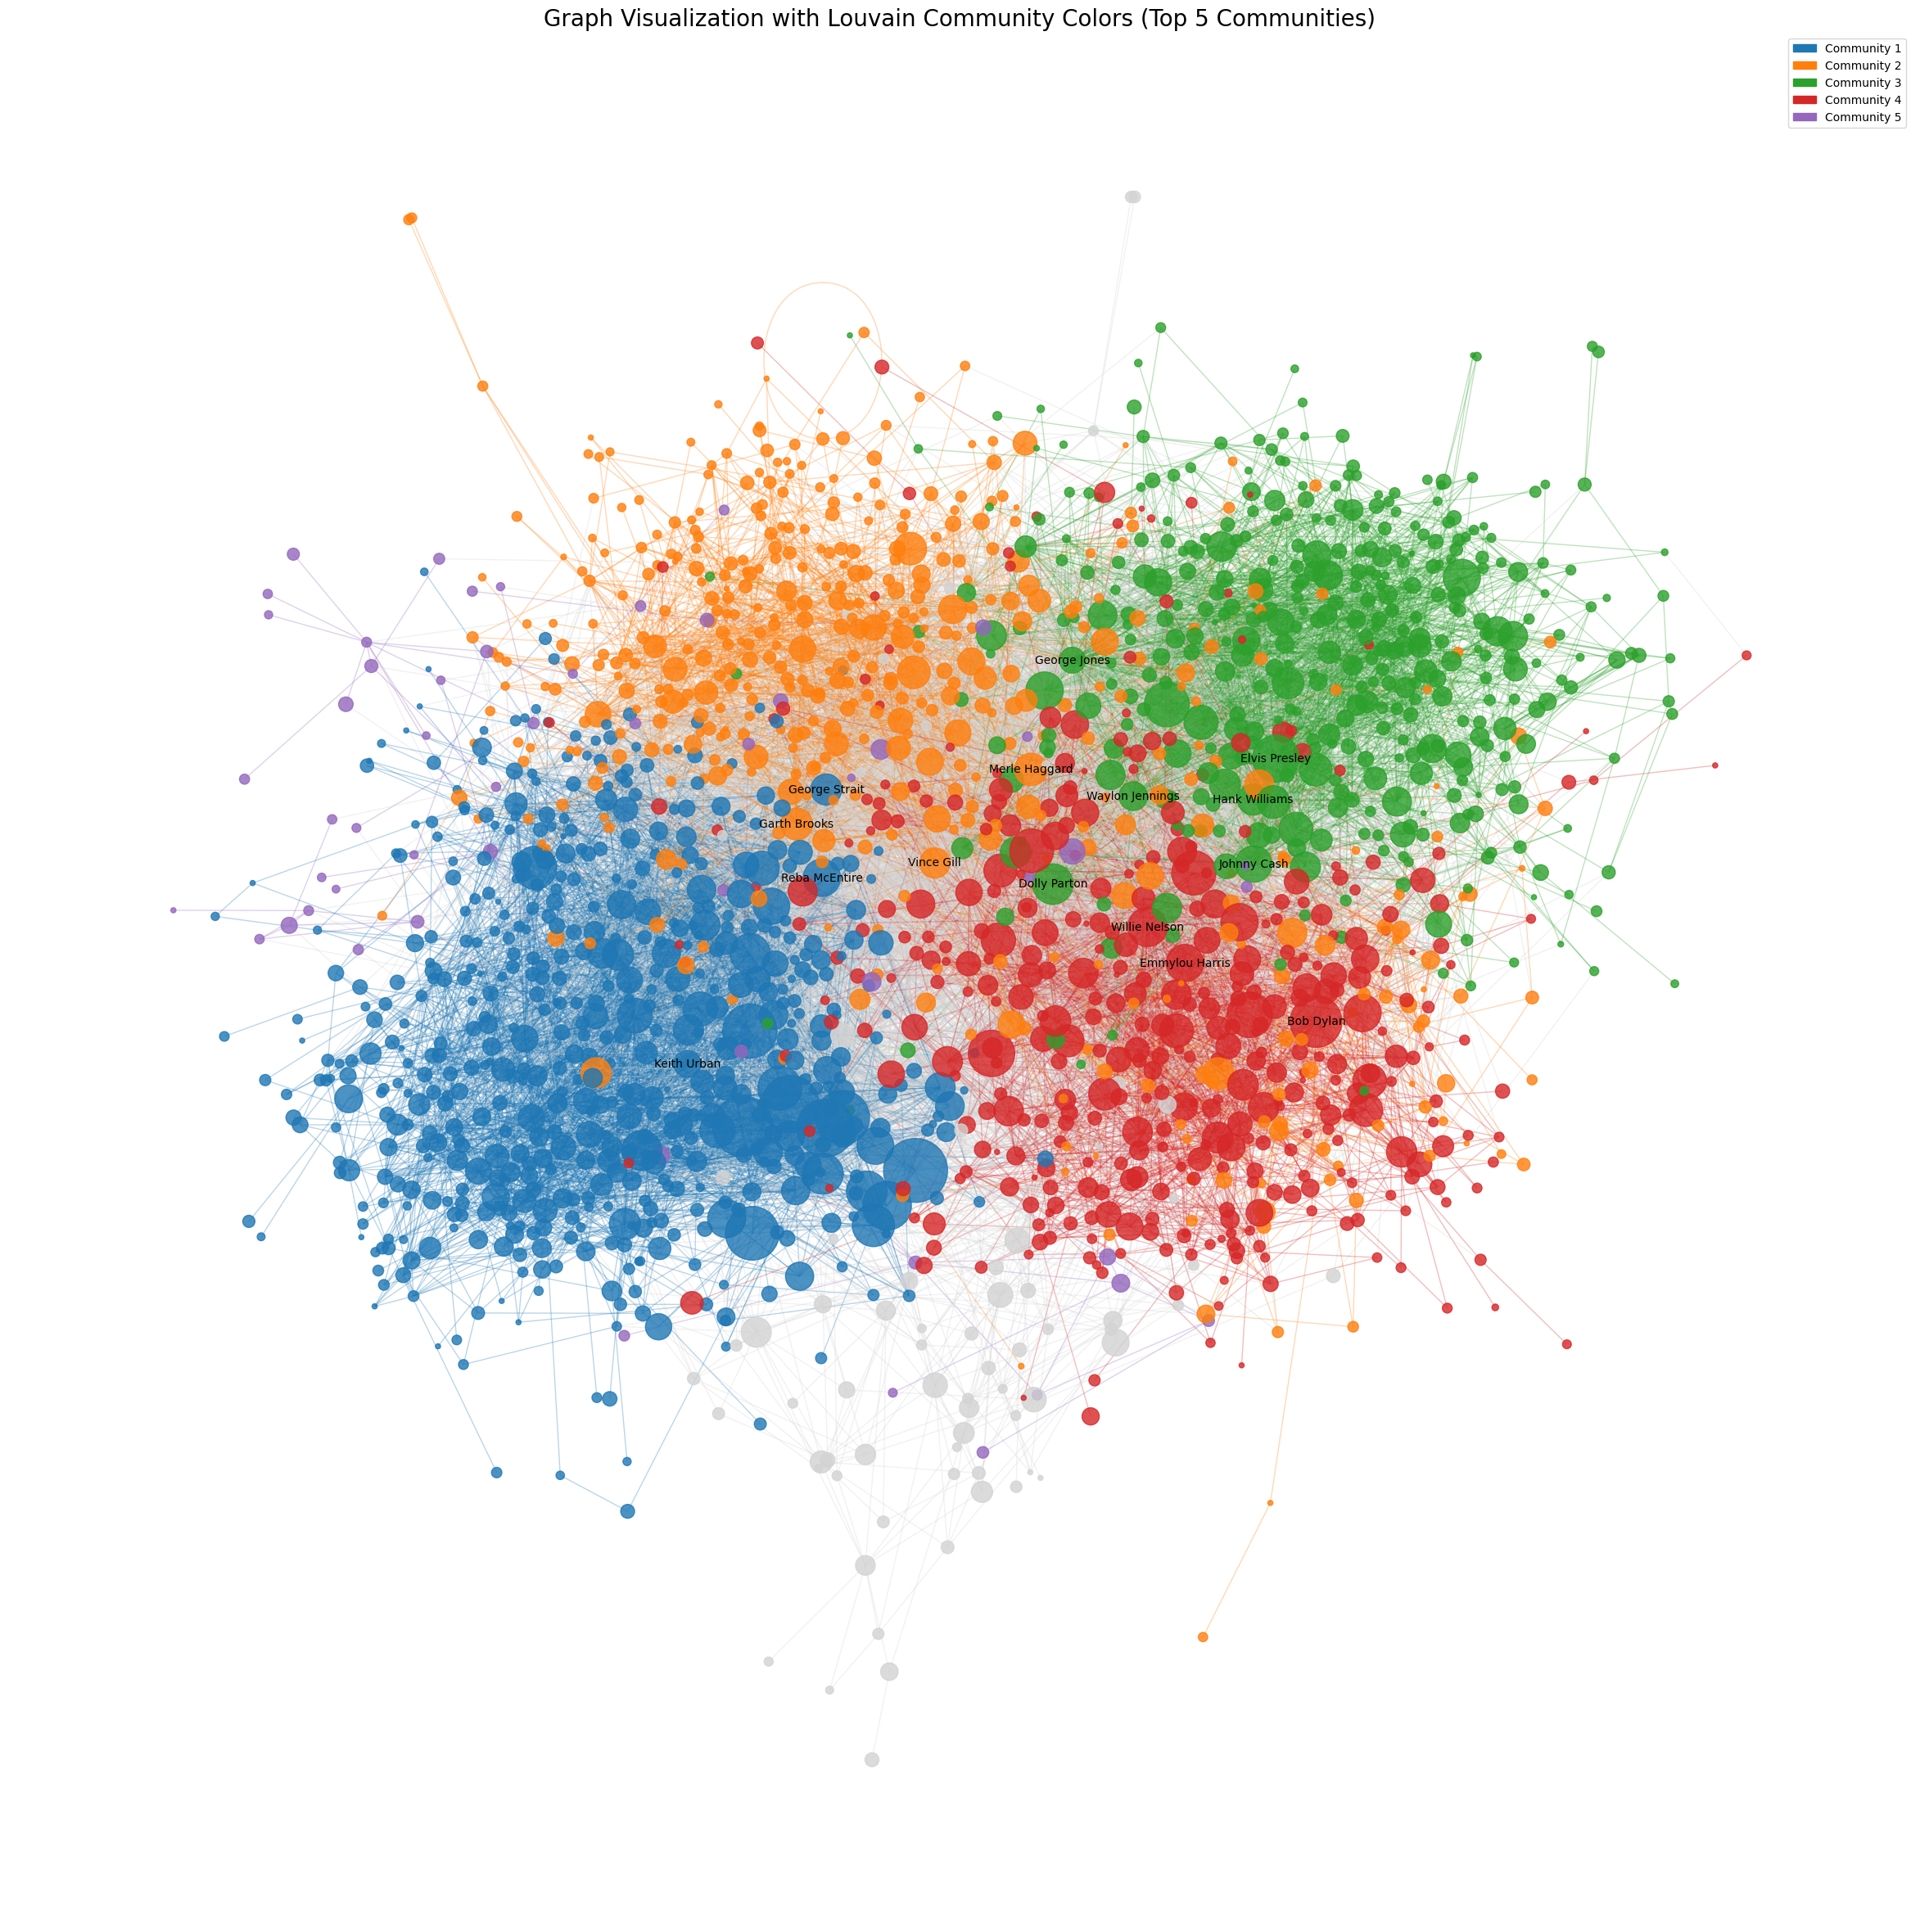

In [104]:
# Initialize ForceAtlas2 for layout generation
forceatlas2 = ForceAtlas2(
    outboundAttractionDistribution=False,
    adjustSizes=False,
    edgeWeightInfluence=0.5,
    jitterTolerance=1, 
    barnesHutOptimize=True,
    barnesHutTheta=0,
    multiThreaded=False,
    scalingRatio=0.000001,
    strongGravityMode=False,
    gravity=0.0001,
    verbose=False
)

# Generate positions using ForceAtlas2
positions = forceatlas2.forceatlas2_networkx_layout(G_undirected, pos=None, iterations=100)

# Plot the graph
plt.figure(figsize=(30, 30))

# Draw nodes with colors and sizes based on Louvain communities and word_count
nx.draw_networkx_nodes(
    G_undirected, 
    positions, 
    node_color=node_colors, 
    node_size=node_sizes, 
    alpha=0.8
)

# Draw edges with colors based on communities
nx.draw_networkx_edges(G_undirected, positions, edge_color=edge_colors, alpha=0.3)

# Label the top 10 artists with the most links
for artist, _ in top_artists:
    x, y = positions[artist]
    plt.text(x, y, artist, fontsize=10, ha='center', va='center', color='black')

# Add legend for top communities
plt.legend(handles=legend_handles, loc='best')
plt.title("Graph Visualization with Louvain Community Colors (Top 5 Communities)", fontsize=20)
plt.axis('off')
plt.show()


1. **Community Characteristics**:
   - **Orange Community**: Positioned on the left side, this cluster appears dense with a few prominent nodes (larger nodes), indicating high-degree nodes that may act as hubs or central figures in this community. The density suggests close internal connections, with many nodes having links within the community.
   - **Red Community**: Located at the bottom, this cluster is relatively compact, with a dense core and a few larger nodes that could represent influential or central nodes within the red community. This structure implies that red community members are tightly interconnected.
   - **Green Community**: Centered in the network, the green community shows a mix of tightly connected nodes and smaller peripheral nodes, giving it a more spread-out appearance than the orange or red communities. It likely serves as a bridge, connecting multiple communities due to its central location.
   - **Blue Community**: Found on the right side, the blue community is the largest and most spread out. Its members are densely connected within the community, but it also has a wider distribution of nodes, suggesting a large, cohesive group with potential connections to other communities.
   - **Purple Community**: While less prominent than the others, the purple community has a few nodes scattered throughout the network, with a small concentration near the green community. This may represent a smaller or niche community with limited internal connections or links to other communities.

2. **Prominent Nodes**:
   - Labels on the top artists (with the most links) are visible in each community, helping to identify key members that may serve as influencers, genre representatives, or collaboration hubs.


### Overall Structure and Insights

- **Internal Cohesion**: Each community is highly cohesive, with dense connections within clusters.
- **Community Roles**: The blue and green communities are more spread, potentially indicating broader influences or versatility within the network, while the orange and red communities appear more contained, possibly representing more genre-specific groups.

In [105]:
import numpy as np
import pandas as pd
from collections import Counter

# Assuming `G_undirected` is the graph, `partition` is the Louvain community assignment,
# and each node has a `genre` attribute containing a list of genres.

# Step 1: Identify the 7 most common genres and communities
# Gather all genres and communities associated with nodes
all_genres = [genre for artist in G_undirected.nodes for genre in G_undirected.nodes[artist].get('genre', [])]
all_communities = list(partition.values())

# Get the 7 most common genres and communities
top_7_genres = [genre for genre, _ in Counter(all_genres).most_common(7)]
top_7_communities = [community for community, _ in Counter(all_communities).most_common(7)]

# Initialize the confusion matrix D with dimensions (7 x 7)
D = np.zeros((7, 7), dtype=int)

# Create mappings for easy indexing
genre_to_index = {genre: idx for idx, genre in enumerate(top_7_genres)}
community_to_index = {community: idx for idx, community in enumerate(top_7_communities)}

# Step 2: Populate the confusion matrix
for artist in G_undirected.nodes:
    genres = G_undirected.nodes[artist].get('genre', [])
    community = partition[artist]

    # Only consider genres and communities in the top 7 lists
    if community in top_7_communities:
        community_idx = community_to_index[community]
        for genre in genres:
            if genre in top_7_genres:
                genre_idx = genre_to_index[genre]
                D[genre_idx, community_idx] += 1

# Step 3: Convert matrix to DataFrame for readability
D_df = pd.DataFrame(D, index=top_7_genres, columns=[f'Community {i+1}' for i in range(7)])

# Display the confusion matrix
print(D_df)  # Use print to display in a standard Python environment


              Community 1  Community 2  Community 3  Community 4  Community 5  \
country               452          385          316          248           49   
folk                   10           29           29           98           10   
country rock           54           28           12           65            1   
americana              15           20           11          102            3   
pop                    54           15           46           37            2   
bluegrass              11           75            7           35            0   
rock                   24           17           14           51            5   

              Community 6  Community 7  
country                30            7  
folk                    1            0  
country rock            3            6  
americana               1            5  
pop                     2            0  
bluegrass               0            0  
rock                    3            2  


1. **Country**: Dominates in **Communities 1, 2,** and **3**. This broad spread shows country’s strong structural influence across multiple communities.

2. **Folk**: Concentrated in **Community 4**, indicating a tight-knit community with limited overlap with other genres.

3. **Country Rock**: Spread across **Communities 1, 2, 3,** and **4**, reflecting its hybrid nature and connections to both country and rock.

4. **Americana**: Primarily in **Community 4**, aligning with folk and suggesting a distinct roots-based community.

5. **Pop**: Spread across **Communities 1, 3,** and **4**, showing weak alignment with any single community, consistent with pop’s genre-blending nature.

6. **Bluegrass**: Predominantly in **Community 2**, forming a unique, cohesive community with minimal cross-genre links.

7. **Rock**: Distributed across communities, particularly **Community 4**, indicating versatility and connections with multiple genres.

### Summary

- **Aligned Genres**: Folk, americana, and bluegrass show strong alignment with specific communities, indicating clear structural identities.
- **Dispersed Genres**: Pop and rock are spread across communities, suggesting weaker structural cohesion and more cross-genre interactions.
- **Key Communities**: Community 1 and 2 are dominated by country; Community 4 focuses on folk and americana.